<a href="https://colab.research.google.com/github/jeffblackadar/crane-pompeii/blob/master/text_on_map_transcription_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses Azure Cognitive Services to transcribe text on an old map.
It then puts the text with its geographic location into a shapefile.
A blog post about it is here: http://jeffblackadar.ca/

In [1]:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
# !apt-get install libgeos-3.6.2 (I am not sure if this is needed)
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install geopandas
!pip install contextily
!pip install -U rasterio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (97.7 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     / 205.1MB 1.5MB/s
     |████████████████████████████████| 6.5MB 9.4MB/s 
     |████████████████████████████████| 225kB 52.3MB/s 
  Created wheel for basemap: filename=basemap

     |████████████████████████████████| 972kB 8.1MB/s 
     |████████████████████████████████| 14.8MB 337kB/s 
     |████████████████████████████████| 18.3MB 249kB/s 
Requirement already up-to-date: rasterio in /usr/local/lib/python3.6/dist-packages (1.1.8)


In [1]:
!pip install --upgrade azure-cognitiveservices-vision-computervision

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
settings_path = "/content/drive/MyDrive/william_white/"
    
import os
import json
# Set the file we wan!pip install --upgrade azure-cognitiveservices-vision-computervisiont to use for authenticating an Azure app
# The json file stores the COMPUTER_VISION_SUBSCRIPTION_KEY and COMPUTER_VISION_ENDPOINT so we don't have it in the code.
# The json file looks like this:
# {
# "COMPUTER_VISION_SUBSCRIPTION_KEY":"___the_COMPUTER_VISION_SUBSCRIPTION_KEY___",
# "COMPUTER_VISION_ENDPOINT":"___the_COMPUTER_VISION_ENDPOINT___"
# }
# cv.json contains the credentials for this program.
cv_settings_file = settings_path+'cv.json'
with open(cv_settings_file, "r") as read_file:
    cv_auth_data = json.load(read_file)

os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']=cv_auth_data["COMPUTER_VISION_SUBSCRIPTION_KEY"]
os.environ['COMPUTER_VISION_ENDPOINT']=cv_auth_data["COMPUTER_VISION_ENDPOINT"]

In [4]:
# https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/python-sdk
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

In [5]:
# Add your Computer Vision subscription key to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()
# Add your Computer Vision endpoint to your environment variables.
if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
else:
    print("\nSet the COMPUTER_VISION_ENDPOINT environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()

In [6]:
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [7]:
'''
Batch Read File, recognize printed text - remote
This example will extract printed text in an image, then print results, line by line.
This API call can also recognize handwriting (not shown).
'''
print("===== Batch Read File - remote =====")
# Get an image with printed text
remote_image_handw_text_url = "http://jeffblackadar.ca/charcoal_hearths/UnionTshp_1876%20clip_georef.tif"

# Call API with URL and raw response (allows you to get the operation location)
recognize_handw_results = computervision_client.read(remote_image_handw_text_url,  raw=True)

===== Batch Read File - remote =====


In [8]:
# Get the operation location (URL with an ID at the end) from the response
operation_location_remote = recognize_handw_results.headers["Operation-Location"]
# Grab the ID from the URL
operation_id = operation_location_remote.split("/")[-1]

# Call the "GET" API and wait for it to retrieve the results 
while True:
    get_handw_text_results = computervision_client.get_read_result(operation_id)
    if get_handw_text_results.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Print the detected text, line by line
lines_of_text = []
if get_handw_text_results.status == OperationStatusCodes.succeeded:
    for text_result in get_handw_text_results.analyze_result.read_results:
        for line in text_result.lines:
            line_data = []  
            print(line.text)
            line_data.append(line.text)
            # print(line.bounding_box)
            line_data.append(line.bounding_box)
            lines_of_text.append(line_data)
print()

H.Beard
F. Mostaller-
H.Hirtint
260
SCHOOL
DIST.
H.Shingle
Eisprung No. 1
A. Wamsher
285
P.MiGahey
H Kirlin
Long
A.5 Felix
S.H ..
F. Howk.
Hill
Heller
Bear
SCHOOL
DIST.
No. 7
200
.F.Jones
Hill
I. stonemetz -..
A.S. Felix
E. Wamsher
.Z. Miller
640
Geo Henderson
J. Ilcien
.H. F. Kirkin
W. Albright .
. J. Mullen
.Fulbert
G . Cpones
3. Yeager
L. Miller LDeffart
"t. Zinn.
mshet 1004.
.A.Grubbe
M.E.ch
*~Mrs. S. High
C. Butler Mhh,
D.Nixon
D.Jones
J. Hoffman
260
= Z. Wolf
tieigerkorn
RD. Wamsher
Brush
Staling 192
H.Cole
.L.Geiger
J.Cole
BR
towan
St. Pauls.
s. Wolf
730
Meth.G.
Miller
.SAKY. SCHOOL
DIST.
No. 8
Mison
ŒU. Geiger
50
n. Geiger
I. Wamsher
G Nullinger
A. Wamsher
Hill
21 stJames
W. Wamsher
Luth.Ch.
J.Geiger
B.Kutz. E Heller "
NOT
N
.IWalters
Clinyen &
Buckley
17
16. Zerr
GEIGERTOWN
286
545
239
Noyer Store
Y. De Hart
D.H.Penn
DIST.
HOPEWELL
French
W. Hoffman
alingan & Mrs. Clintyan
200
J.Houck
J. Murrys
Buckley's .B.S.S.
Williams
Furuures
old Kun
Stutings
SCHOOL
Clingan & Buckley
205
A

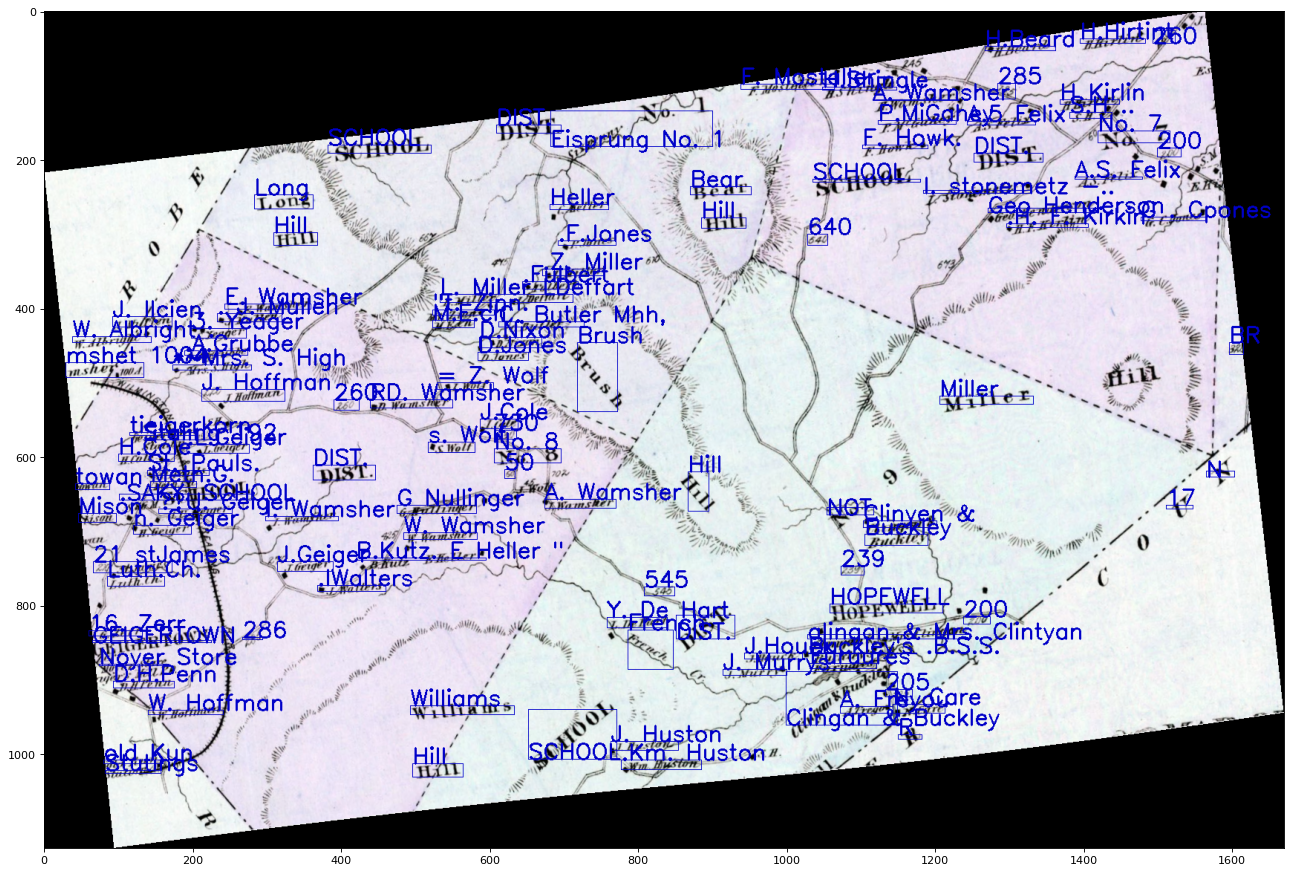

In [9]:
import cv2
import matplotlib.pyplot as plt
import gdal
import geopandas as gpd
from shapely.geometry import Point, Polygon

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1
fontColor              = (0,0,200)
lineType               = 2

# read the image
img = cv2.imread("/content/drive/MyDrive/MaskCNNhearths/HopewellFurnace/UnionTshp_1876 clip_georef.tif",-1)
img_ds = gdal.Open("/content/drive/MyDrive/MaskCNNhearths/HopewellFurnace/UnionTshp_1876 clip_georef.tif") 

#GeoTransform[0] /* top left x */
#GeoTransform[1] /* w-e pixel resolution */
#GeoTransform[2] /* 0 */
#GeoTransform[3] /* top left y */
#GeoTransform[4] /* 0 */
#GeoTransform[5] /* n-s pixel resolution (negative value) */

xoffset, px_w, rot1, yoffset, rot2, px_h  = img_ds.GetGeoTransform()

line_text_poly = gpd.GeoDataFrame()
line_text_poly['geometry'] = None
geotif_crs = 32129
line_text_poly.crs = ("EPSG:" + str(geotif_crs))
line_text_poly.geometry = line_text_poly.geometry.to_crs(crs=geotif_crs)
line_text_poly.to_crs(crs=geotif_crs)
line_text_poly = line_text_poly.to_crs(epsg=geotif_crs)

# thanks to https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
def get_point_from_pixel(x,y, xoffset, px_w, rot1, yoffset, px_h, rot2):
    # supposing x and y are your pixel coordinate this 
    # is how to get the coordinate in space.
    posX = px_w * x + rot1 * y + xoffset
    posY = rot2 * x + px_h * y + yoffset

    posX = (px_w * x) + (rot1 * y) + xoffset
    posY = (px_h * y) + (rot2 * x) + yoffset
    # shift to the center of the pixel
    posX += px_w / 2.0
    posY += px_h / 2.0
    return(posX,posY)
    
ln = 0
for l in lines_of_text:
    pts = l[1]
    # add text
    cv2.putText(img, l[0], (int(pts[0]),int(pts[1])),  font,  fontScale,  fontColor, lineType)
    # add rectangle
    cv2.rectangle(img,(int(pts[0]),int(pts[1])),(int(pts[4]),int(pts[5])),fontColor)
  
    p=[]
    for cn in range(0,4):
        p.append(get_point_from_pixel(pts[0+(cn*2)],pts[1+(cn*2)], xoffset, px_w, rot1, yoffset, px_h, rot2))
    coords = [(p[0][0], p[0][1]), (p[1][0], p[1][1]), (p[2][0], p[2][1]), (p[3][0], p[3][1])]
    
    poly = Polygon(coords)
    new_tp_row = {'id':ln, 'geometry':poly,'text':l[0]}
    line_text_poly = line_text_poly.append(new_tp_row, ignore_index=True)
    
line_text_poly.to_file("line_text.shp")
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import pandas as pd
import contextily as ctx

epsg:32129
epsg:3857


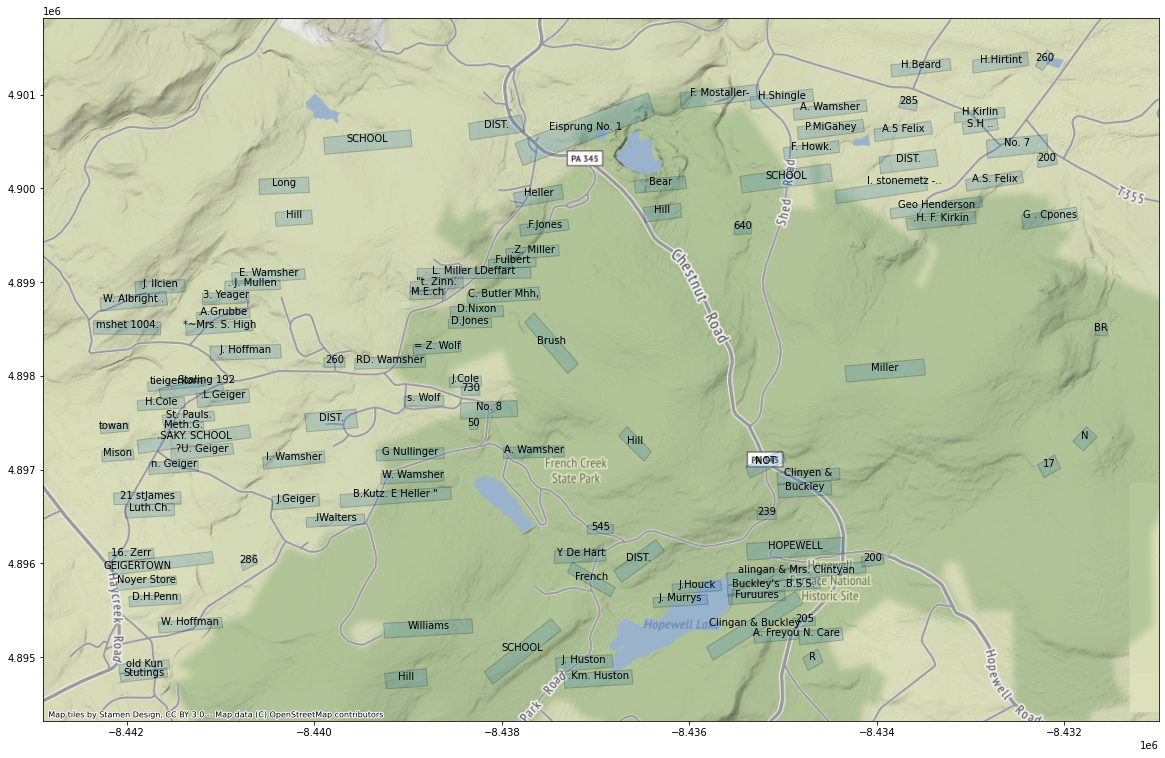

In [11]:
line_text_df=gpd.read_file("/content/line_text.shp")

print(line_text_df.crs)
# Change crs to one compatible with basemap
line_text_df = line_text_df.to_crs(epsg=3857) #3857
print(line_text_df.crs)

ax = line_text_df.plot(figsize=(20, 20), alpha=0.2, edgecolor='k')
ctx.add_basemap(ax)

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'],
                 horizontalalignment='center')

Download /content/line_text.shp to use it in other maps such as ArcGIS Map. 